In [144]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import anndata as ad
import scanpy as sc
import seaborn as sns
from fs import open_fs
from matplotlib_scalebar.scalebar import ScaleBar
from tqdm import tqdm
from skimage.measure import block_reduce
import tifffile
import string

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')
    
# Function to preprocess raw AnnData object

def preprocess_ad(ad, min_counts):
    ad.layers['counts'] = ad.X.copy()
    sc.pp.filter_cells(ad, min_counts=min_counts)
    sc.pp.normalize_total(ad, target_sum=1e4) # Normalize data
    sc.pp.log1p(ad) # Logarithmize the data
    sc.pp.scale(ad) # Scale each gene to unit variance

In [105]:
# Load postprocessed MERFISH and MACA results

# Define the path of the analyzed MERFISH data
dataPathPost = '../../../results'

# Define the experiments
experimentName = ['MsLiver_Cellbound_VZG116_V1_JH_09-18-2021', 
                  'MsKidney_CellBoundary_VZG116_111921']
suffixCountsFilter = '_FilteredSingleCellCounts.h5ad'

VizgenCountsFilter = []

for i in range(len(experimentName)):
    # Filtered counts per segmented cell
    VizgenCountsFilter.append(ad.read_h5ad(os.path.join(dataPathPost, 
                                                        experimentName[i] + suffixCountsFilter)))
    

# Convert all gene names to lower case
for i in range(len(experimentName)):
    VizgenCountsFilter[i].var.index = VizgenCountsFilter[i].var.index.str.lower()
    
# Rename the 5 genes that are inconsistent with MACA (NOTE: MIR205HG doesn't seem to be in MACA at all)
rename_map = {'mir205hg':'4631405k08rik',
             'ackr1':'darc',
             'adgrl4':'eltd1',
             'cavin2':'sdpr',
             'jchain':'igj'}
for i in range(len(experimentName)):
    gene_list = list(VizgenCountsFilter[i].var.index)
    for j in range(len(gene_list)):
        if gene_list[j] in rename_map.keys():
            gene_list[j] = rename_map[gene_list[j]]
    VizgenCountsFilter[i].var.index = gene_list


# Combine into single tissue objects
liver_ind = [0]
kidney_ind = [1]
VizgenLiver_all = []
VizgenKidney_all = []

for i in liver_ind:
    VizgenLiver_all.append(VizgenCountsFilter[i])
    
for i in kidney_ind:
    VizgenKidney_all.append(VizgenCountsFilter[i])

VizgenLiver = VizgenLiver_all[0]
for i in range(len(liver_ind)-1):
    VizgenLiver = VizgenLiver.concatenate(VizgenLiver_all[liver_ind[i+1]])
    
VizgenKidney = VizgenKidney_all[0]
for i in range(len(kidney_ind)-1):
    VizgenKidney = VizgenKidney.concatenate(VizgenKidney_all[kidney_ind[i+1]])

# Preprocess data
preprocess_ad(VizgenLiver, 80)
preprocess_ad(VizgenKidney, 80)

print('Data loaded and preprocessed.')

Data loaded and preprocessed.


In [155]:
# UMAP and leiden clustering
# Get UMAP of liver
sc.tl.pca(VizgenLiver, svd_solver='arpack') #Compute PCA
sc.pp.neighbors(VizgenLiver) #Compute neighborhood graph
sc.tl.umap(VizgenLiver)
sc.tl.leiden(VizgenLiver, resolution=1)

print('UMAP and leiden clustering computed.')

UMAP and leiden clustering computed.


In [188]:
# Kidney
sc.tl.pca(VizgenKidney, svd_solver='arpack') #Compute PCA
sc.pp.neighbors(VizgenKidney, n_neighbors=15) #Compute neighborhood graph
sc.tl.umap(VizgenKidney)
sc.tl.leiden(VizgenKidney, resolution=0.5)

print('UMAP and leiden clustering computed.')

UMAP and leiden clustering computed.


<Figure size 640x480 with 0 Axes>

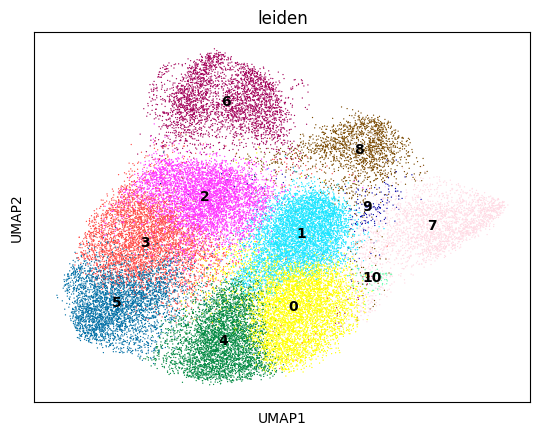

KeyError: "Could not find entry in `obsm` for 'umap'.\nAvailable keys are: ['spatial']."

<Figure size 640x480 with 0 Axes>

In [156]:
# Plot the UMAPs
plt.figure()
sc.pl.umap(VizgenLiver, color='leiden', legend_loc='on data', show=False)
plt.show()

plt.figure()
sc.pl.umap(VizgenKidney, color='leiden', legend_loc='on data', show=False)
plt.show()

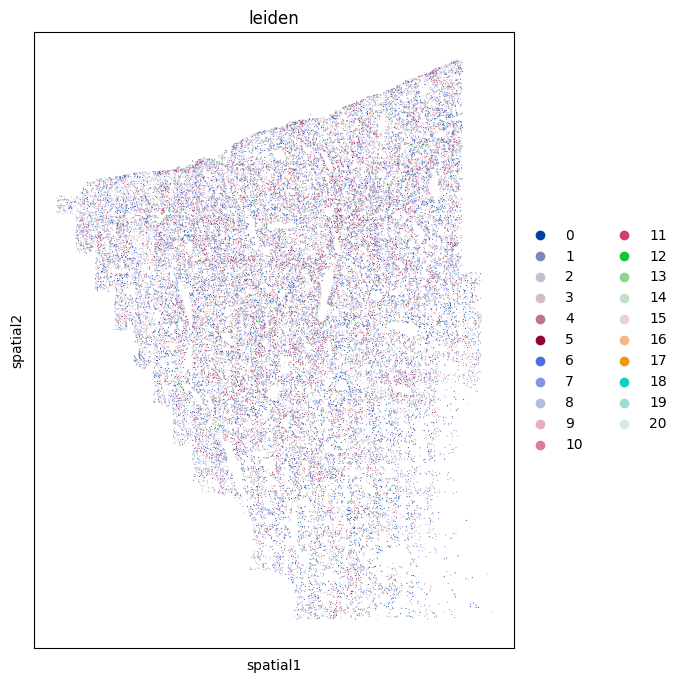

KeyError: 'Could not find key leiden in .var_names or .obs.columns.'

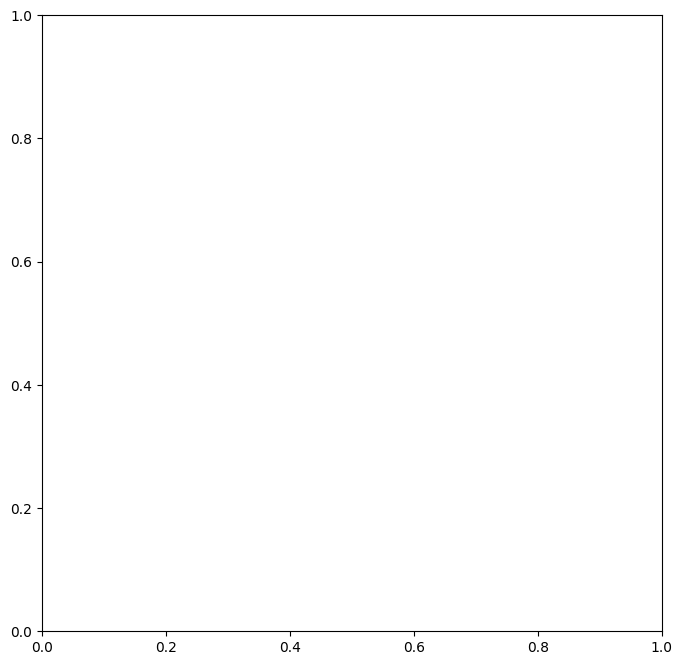

In [108]:
# Spatial plots
fig, ax = plt.subplots(figsize=(8,8))
sc.pl.spatial(VizgenLiver, color='leiden', spot_size=100, show=False, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(8,8))
sc.pl.spatial(VizgenKidney, color='leiden', spot_size=100, show=False, ax=ax)
plt.show()

<Figure size 640x480 with 0 Axes>

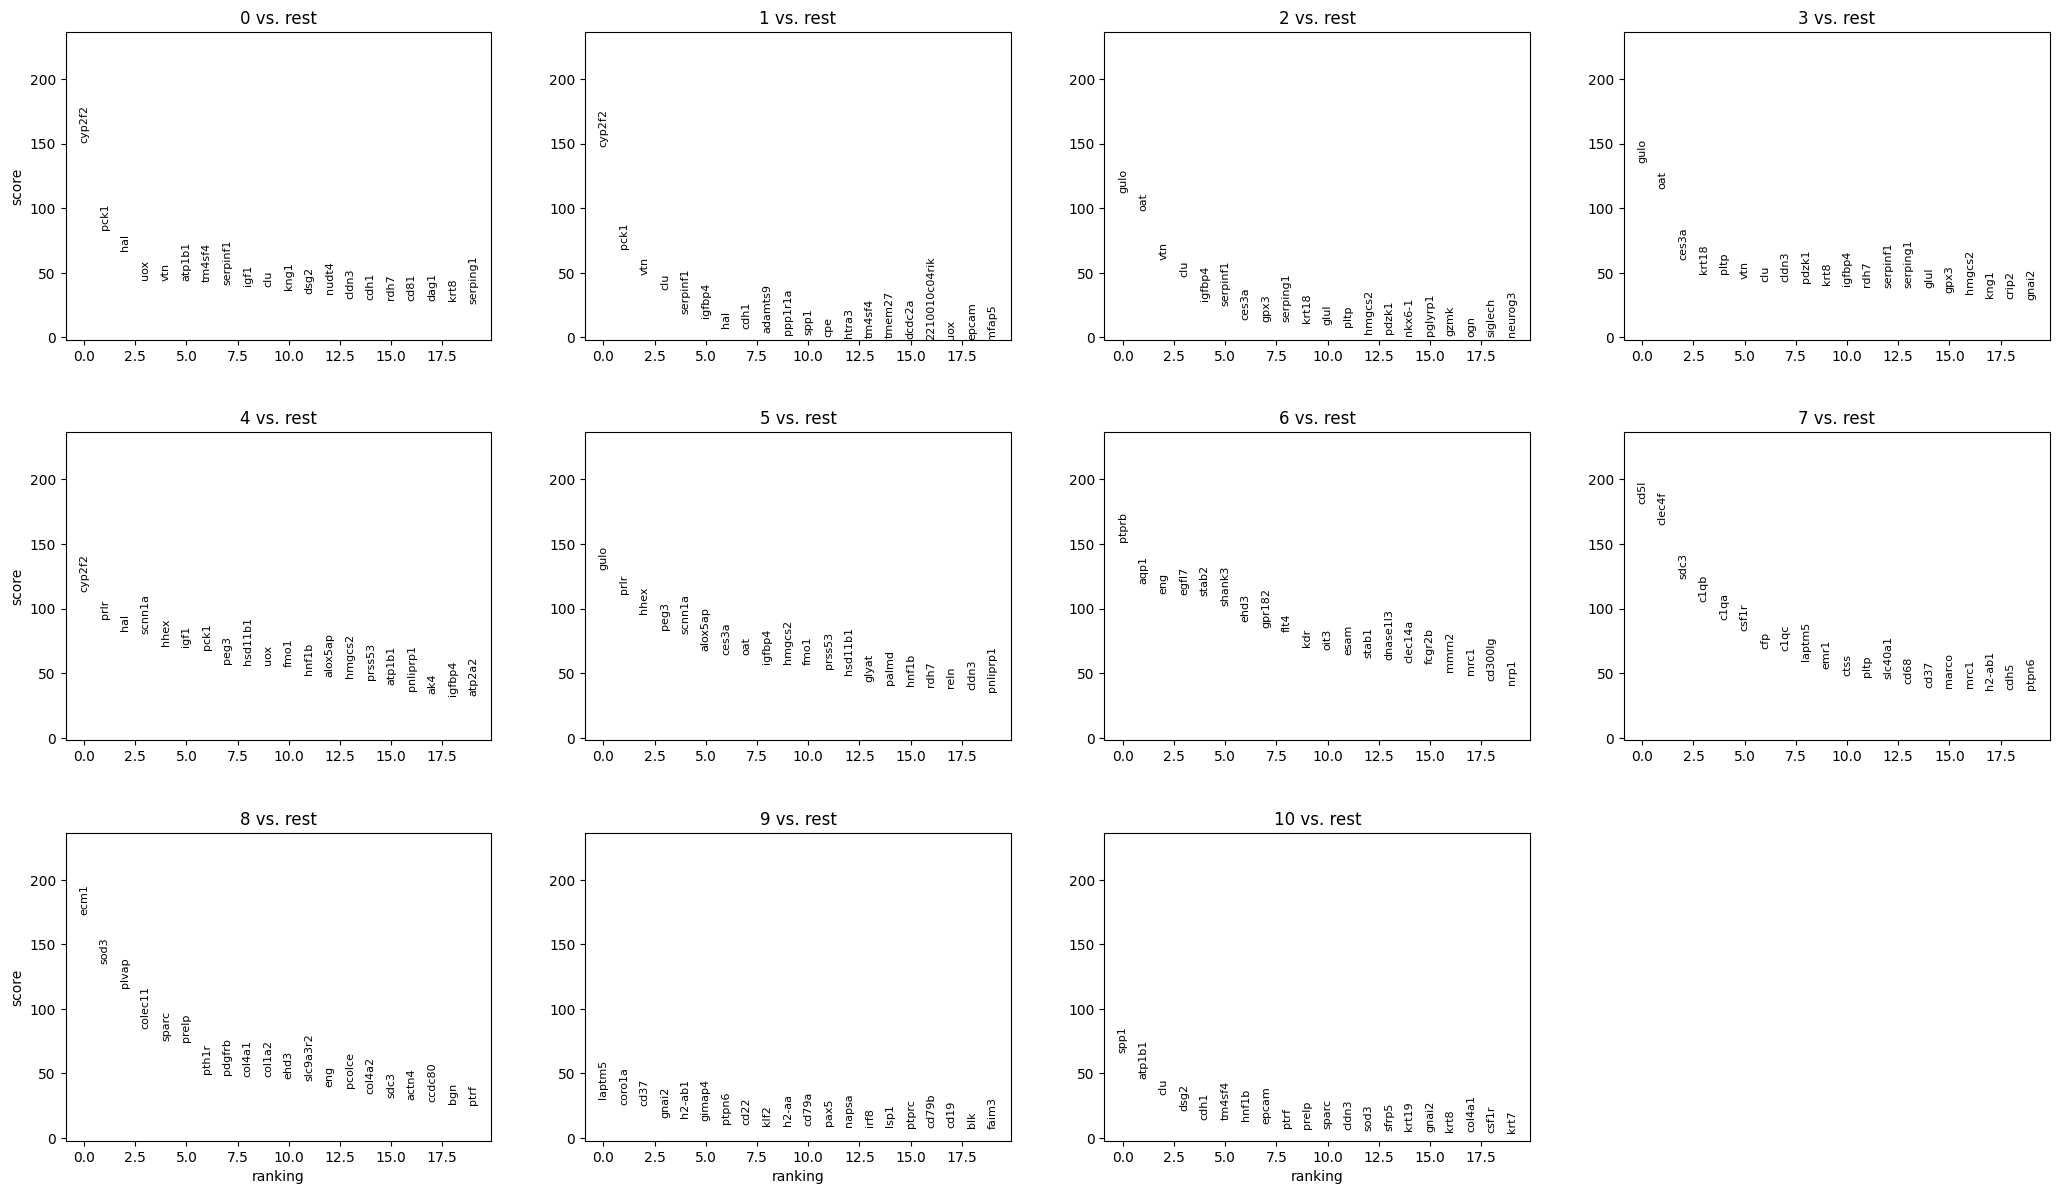

<Figure size 640x480 with 0 Axes>

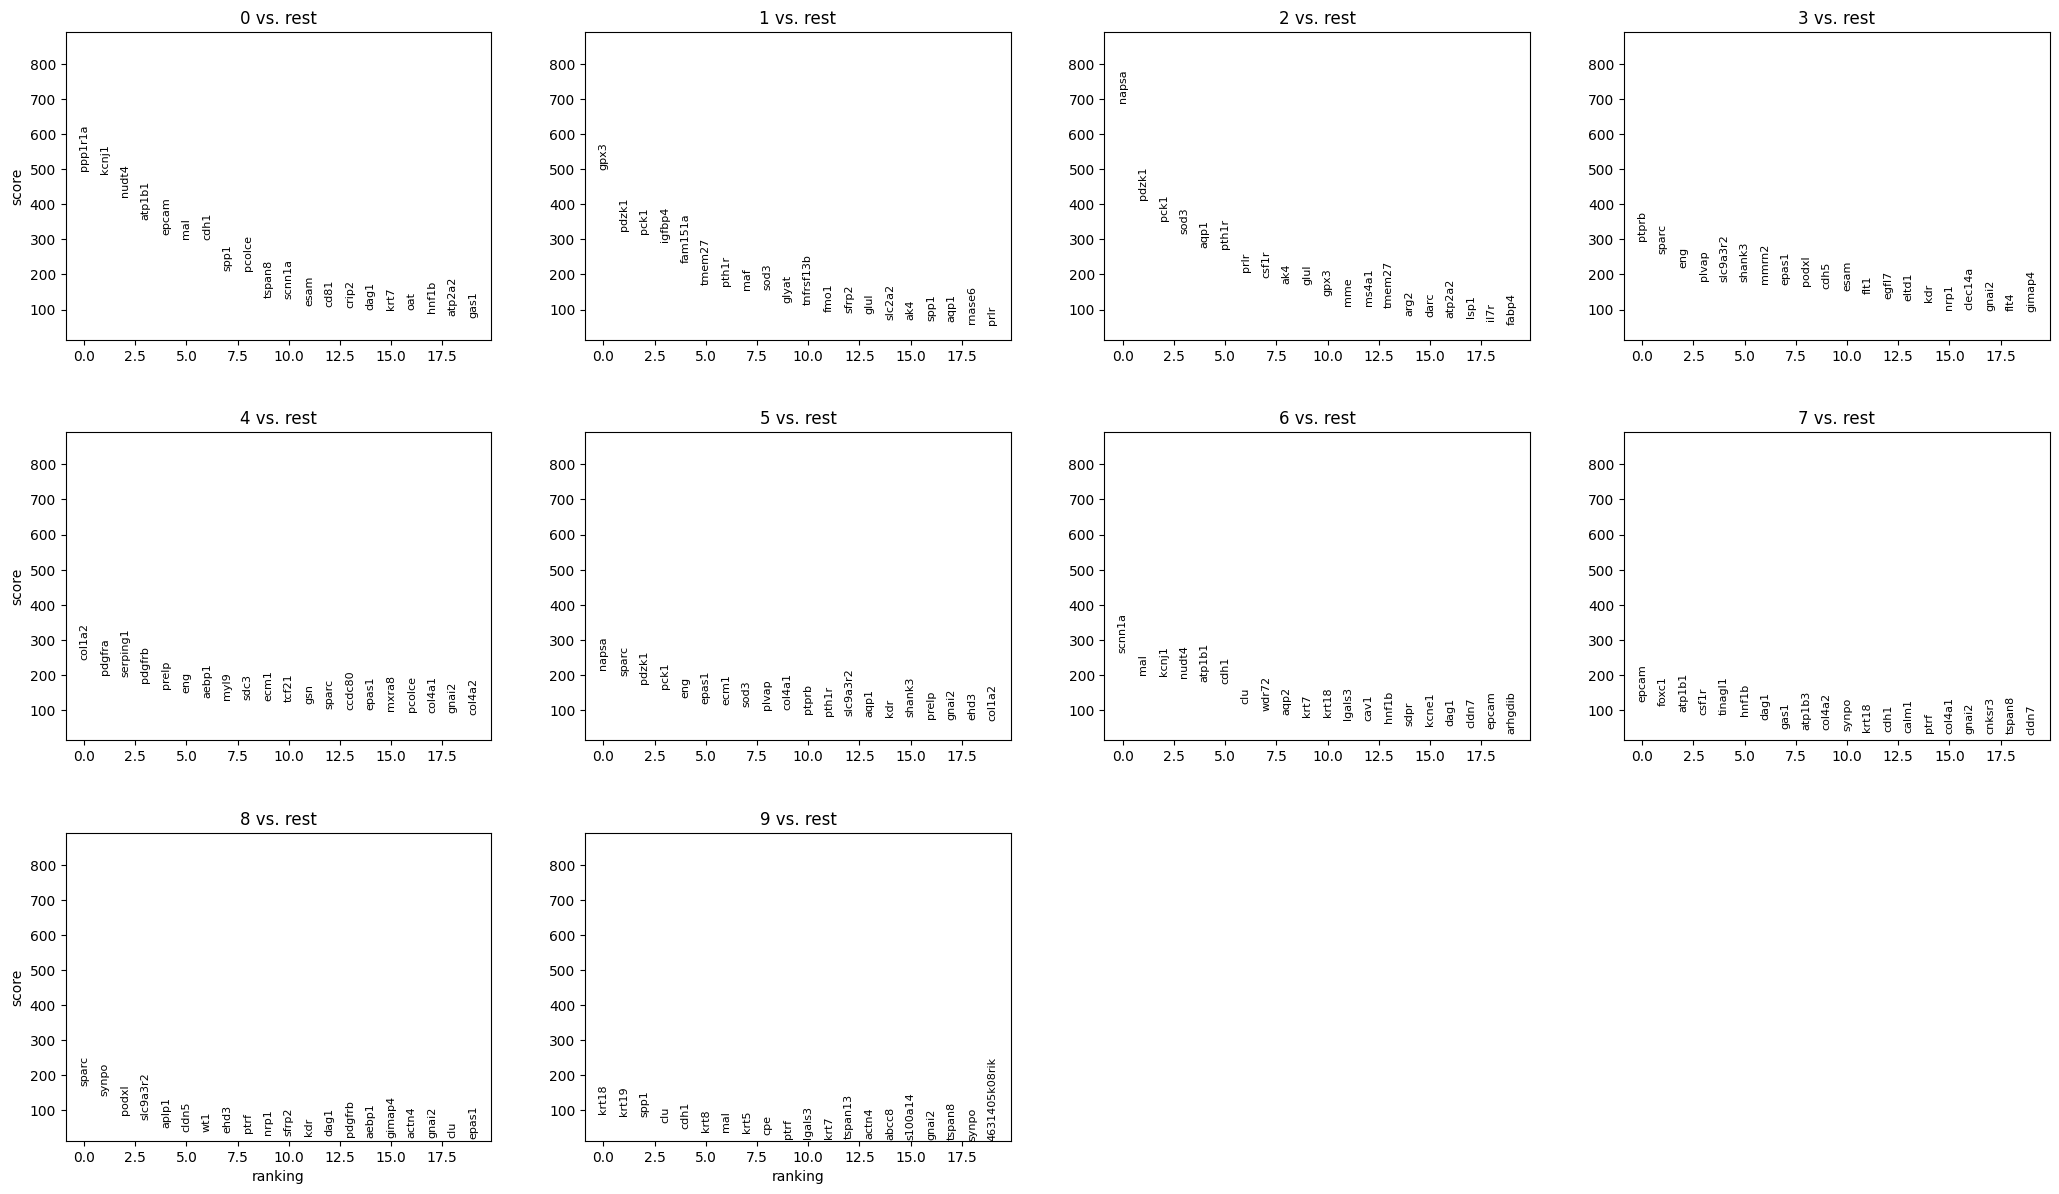

In [195]:
# Plot marker genes
sc.tl.rank_genes_groups(VizgenLiver, 'leiden')
sc.tl.rank_genes_groups(VizgenKidney, 'leiden')

plt.figure()
sc.pl.rank_genes_groups(VizgenLiver)
plt.show()

plt.figure()
sc.pl.rank_genes_groups(VizgenKidney)
plt.show()

In [196]:
# Get a dataframe for the marker genes
markers_liver = pd.DataFrame(VizgenLiver.uns['rank_genes_groups']['names'])
markers_kidney = pd.DataFrame(VizgenKidney.uns['rank_genes_groups']['names'])

### Liver annotations

In [236]:
'dll4' in VizgenLiver.var.index

False

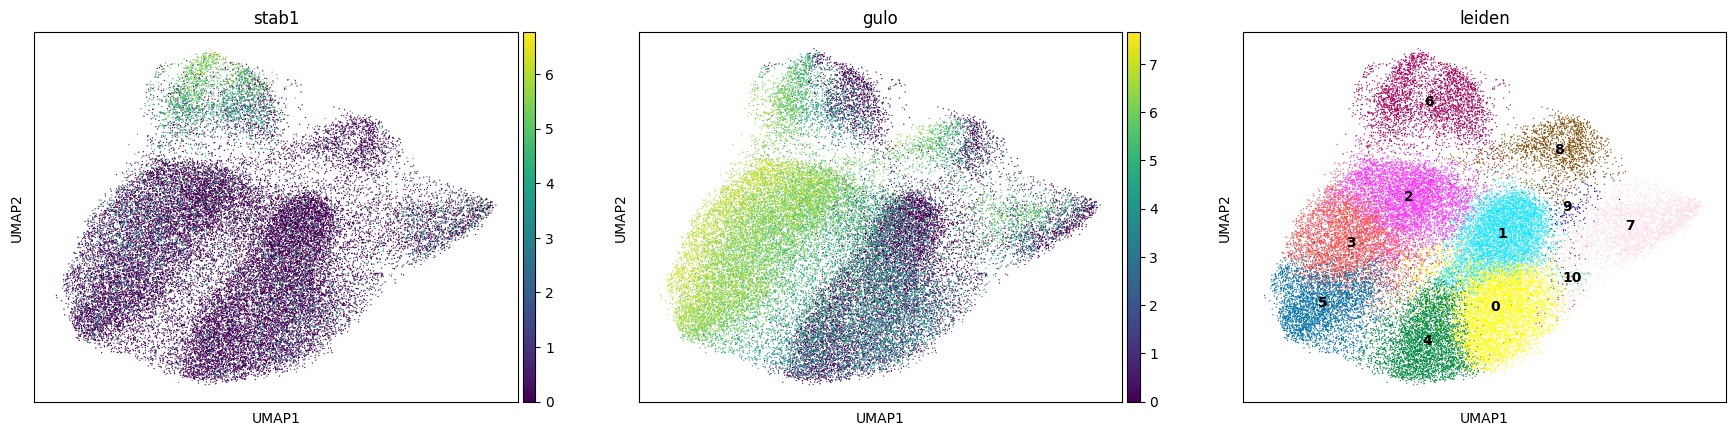

In [159]:
sc.pl.umap(VizgenLiver, color=['stab1','gulo','leiden'],legend_loc='on data')
plt.show()

In [160]:
# Liver cluster marker genes
markers_liver.head(20)

0              1         2         3         4         5         6  \
0     cyp2f2         cyp2f2      gulo      gulo    cyp2f2      gulo     ptprb   
1       pck1           pck1       oat       oat      prlr      prlr      aqp1   
2        hal            vtn       vtn     ces3a       hal      hhex       eng   
3        uox            clu       clu     krt18    scnn1a      peg3     egfl7   
4        vtn       serpinf1    igfbp4      pltp      hhex    scnn1a     stab2   
5     atp1b1         igfbp4  serpinf1       vtn      igf1   alox5ap    shank3   
6     tm4sf4            hal     ces3a       clu      pck1     ces3a      ehd3   
7   serpinf1           cdh1      gpx3     cldn3      peg3       oat    gpr182   
8       igf1        adamts9  serping1     pdzk1   hsd11b1    igfbp4      flt4   
9        clu        ppp1r1a     krt18      krt8       uox    hmgcs2       kdr   
10      kng1           spp1      glul    igfbp4      fmo1      fmo1      oit3   
11      dsg2            cpe      pltp      rdh7     hnf1b    prss53      esam   
12     nudt4          htra3    hmgcs2  serpinf1   alox5ap   hsd11b1     stab1   
13     cldn3         tm4sf4     pdzk1  serping1    hmgcs2     glyat  dnase1l3   
14      cdh1         tmem27    nkx6-1      glul    prss53     palmd   clec14a   
15      rdh7         dcdc2a   pglyrp1      gpx3    atp1b1     hnf1b    fcgr2b   
16      cd81  2210010c04rik      gzmk    hmgcs2  pnliprp1      rdh7     mmrn2   
17      dag1            uox       ogn      kng1       ak4      reln      mrc1   
18      krt8          epcam   siglech     crip2    igfbp4     cldn3   cd300lg   
19  serping1          mfap5   neurog3     gnai2    atp2a2  pnliprp1      nrp1   

          7         8       9      10  
0      cd5l      ecm1  laptm5    spp1  
1    clec4f      sod3  coro1a  atp1b1  
2      sdc3     plvap    cd37     clu  
3      c1qb   colec11   gnai2    dsg2  
4      c1qa     sparc  h2-ab1    cdh1  
5     csf1r     prelp  gimap4  tm4sf4  
6       cfp     pth1r   ptpn6   hnf1b  
7      c1qc    pdgfrb    cd22   epcam  
8    laptm5    col4a1    klf2    ptrf  
9      emr1    col1a2   h2-aa   prelp  
10     ctss      ehd3   cd79a   sparc  
11     pltp  slc9a3r2    pax5   cldn3  
12  slc40a1       eng   napsa    sod3  
13     cd68    pcolce    irf8   sfrp5  
14     cd37    col4a2    lsp1   krt19  
15    marco      sdc3   ptprc   gnai2  
16     mrc1     actn4   cd79b    krt8  
17   h2-ab1    ccdc80    cd19  col4a1  
18     cdh5       bgn     blk   csf1r  
19    ptpn6      ptrf   faim3    krt7

### Preliminary annotating:
- 0 = pericentral hep
- 1-3 = peripotal hep
- 4 = pericentral hep
- 5 = endothelial cell of hepatic sinusoid (aqp1, stab2, egfl7, ptprb, eng, flt4)
- 6 = Kupffer (clec4f)
- 7 = pericentral hep (gulo, oat)
- 8 = stellate cell (bgn, col1a2)
- 9 = endothelial
- 10 = periportal hep (cyp2f2)
- 11 = periportal hep (cyp2f2)
- 12 = recluster immune
- 13 = periportal hep (cyp2f2)
- 14 = unknown (remove? since only 3 cells)

### Free annotations:
- 0 = periportal hepatocyte (cyp2f2, hal)
- 1 = periportal hepatocyte (cyp2f2, hal)
- 2 = pericentral hepatocyte (gulo, oat)
- 3 = pericentral hepatocyte (gulo, oat)
- 4 = periportal hepatocyte (cyp2f2, hal)
- 5 = pericentral hepatocyte (gulo, oat)
- 6 = endothelial (ptprb, aqp1)
- 7 = Kupffer (clec4f)
- 8 = hepatic stellate cell (sod3, ecm1, col1a2)
- 9 = immune cell (laptm5, cd37)
- 10 = bile duct epithelial cell (krt7, krt19, epcam)

In [176]:
liver_map = {'0':'periportal hepatocyte',
             '1': 'periportal hepatocyte',
             '2': 'pericentral hepatocyte',
             '3': 'pericentral hepatocyte',
             '4': 'periportal hepatocyte',
             '5': 'pericentral hepatocyte',
             '6': 'endothelial cell',
             '7': 'Kupffer cell',
             '8': 'hepatic stellate cell',
             '9': 'immune cell',
             '10': 'bile duct epithelial cell'
            }

VizgenLiver.obs['free_annotation'] = VizgenLiver.obs['leiden'].map(liver_map)

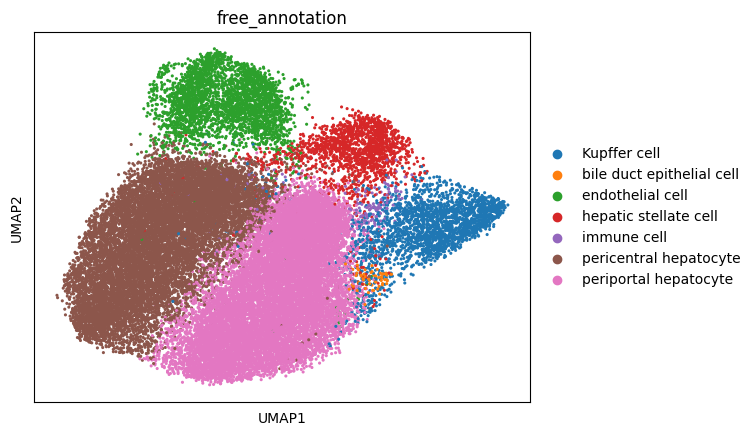

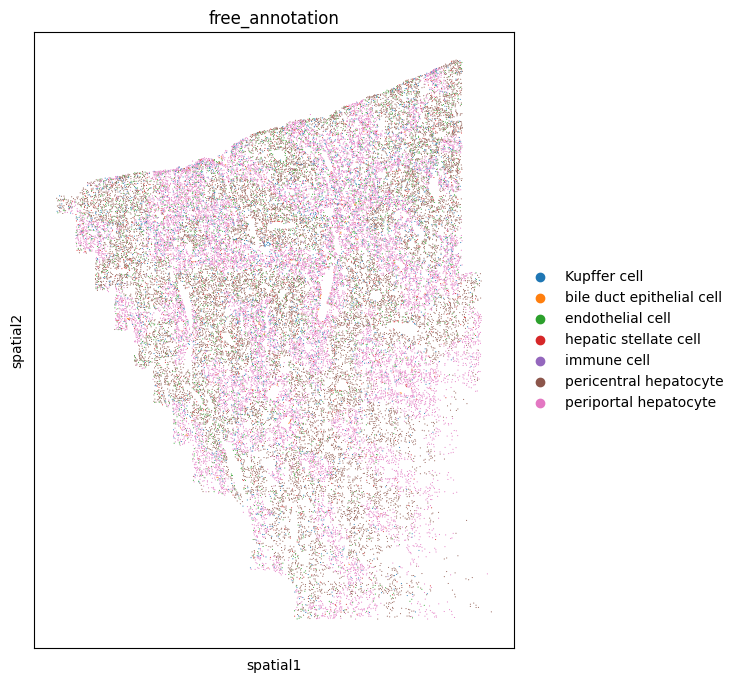

In [163]:
sc.pl.umap(VizgenLiver, color='free_annotation', size=20)
plt.show()

fig, ax = plt.subplots(figsize=(8,8))
sc.pl.spatial(VizgenLiver, color='free_annotation', spot_size=100, show=False, ax=ax)
plt.show()


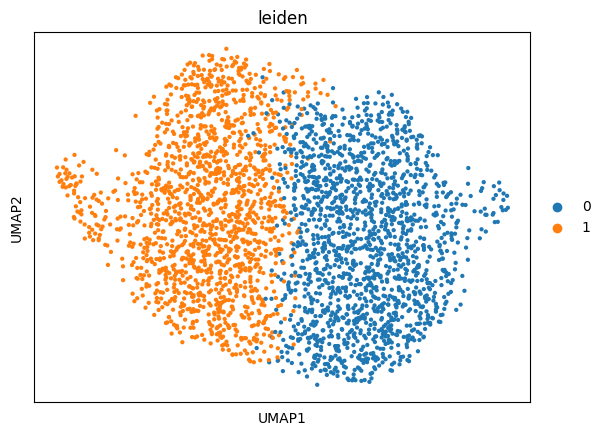

In [166]:
# Subcluster the endothelial cells
VizgenLiver_endo = VizgenLiver[VizgenLiver.obs['free_annotation'] == 'endothelial cell'].copy()

sc.tl.pca(VizgenLiver_endo, svd_solver='arpack') #Compute PCA
sc.pp.neighbors(VizgenLiver_endo) #Compute neighborhood graph
sc.tl.umap(VizgenLiver_endo)
sc.tl.leiden(VizgenLiver_endo, resolution=0.2)
sc.pl.umap(VizgenLiver_endo, color='leiden')

In [167]:
# Get the subclustered DE genes
sc.tl.rank_genes_groups(VizgenLiver_endo, 'leiden')
markers_liver_endo = pd.DataFrame(VizgenLiver_endo.uns['rank_genes_groups']['names'])
markers_liver_endo.head(20)

0        1
0     cyp2f2      oat
1       pck1     gulo
2        hal     glul
3        uox    stab1
4       cdh1     gpx3
5     atp1b1   shank3
6        ak4     pltp
7       igf1    stab2
8     tm4sf4      eng
9       ldb2   col4a1
10       vtn   col4a2
11       clu    ces3a
12   slc40a1  tinagl1
13      spp1     ecm1
14    coro1a    egfl7
15  serpinf1      kdr
16      kng1     oit3
17    clec4f      maf
18      gas1    plvap
19     marco   gimap4

- 0 = periportal endothelial
- 1 = pericentral endothelial

In [177]:
# Annotate and transfer back to master liver object

liver_endo_map = {'0':'periportal endothelial cell',
                  '1': 'pericentral endothelial cell'
                 }

VizgenLiver_endo.obs['free_annotation'] = VizgenLiver_endo.obs['leiden'].map(liver_endo_map)

for ind in VizgenLiver_endo.obs.index:
    VizgenLiver.obs.loc[ind,'free_annotation'] = VizgenLiver_endo.obs.loc[ind,'free_annotation']

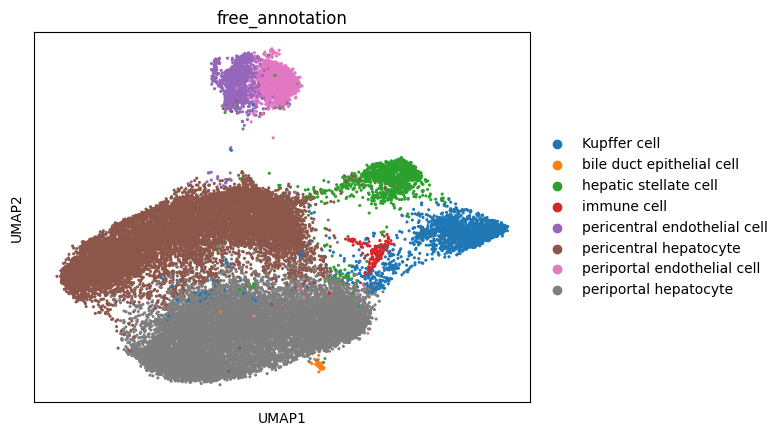

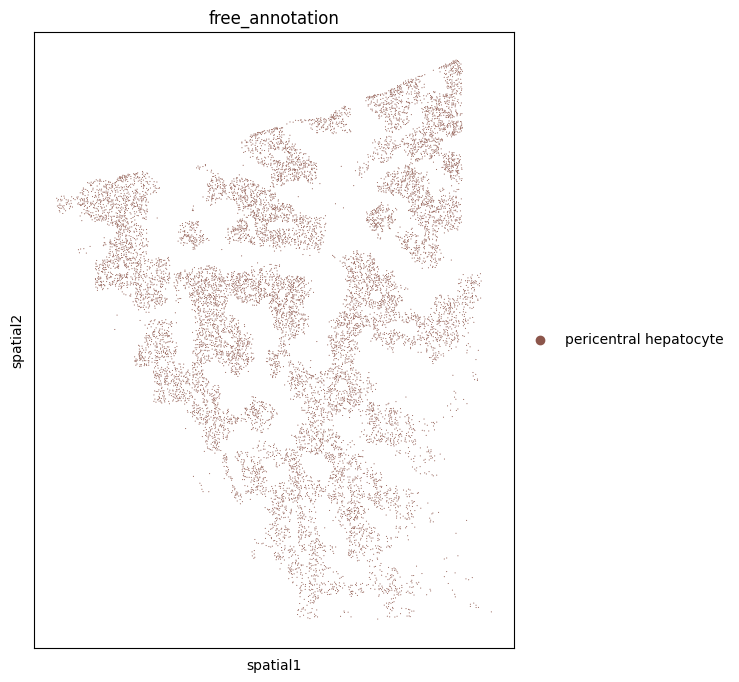

In [189]:
# Visualize the final results
sc.tl.umap(VizgenLiver, min_dist=0.01)
sc.pl.umap(VizgenLiver, color='free_annotation', size=20)
plt.show()

fig, ax = plt.subplots(figsize=(8,8))
sc.pl.spatial(VizgenLiver[
    VizgenLiver.obs['free_annotation'] == 'pericentral hepatocyte'], 
              color='free_annotation', spot_size=100, show=False, ax=ax)
plt.show()


### Kidney annotations

In [ ]:
'clu' in VizgenKidney.var.index

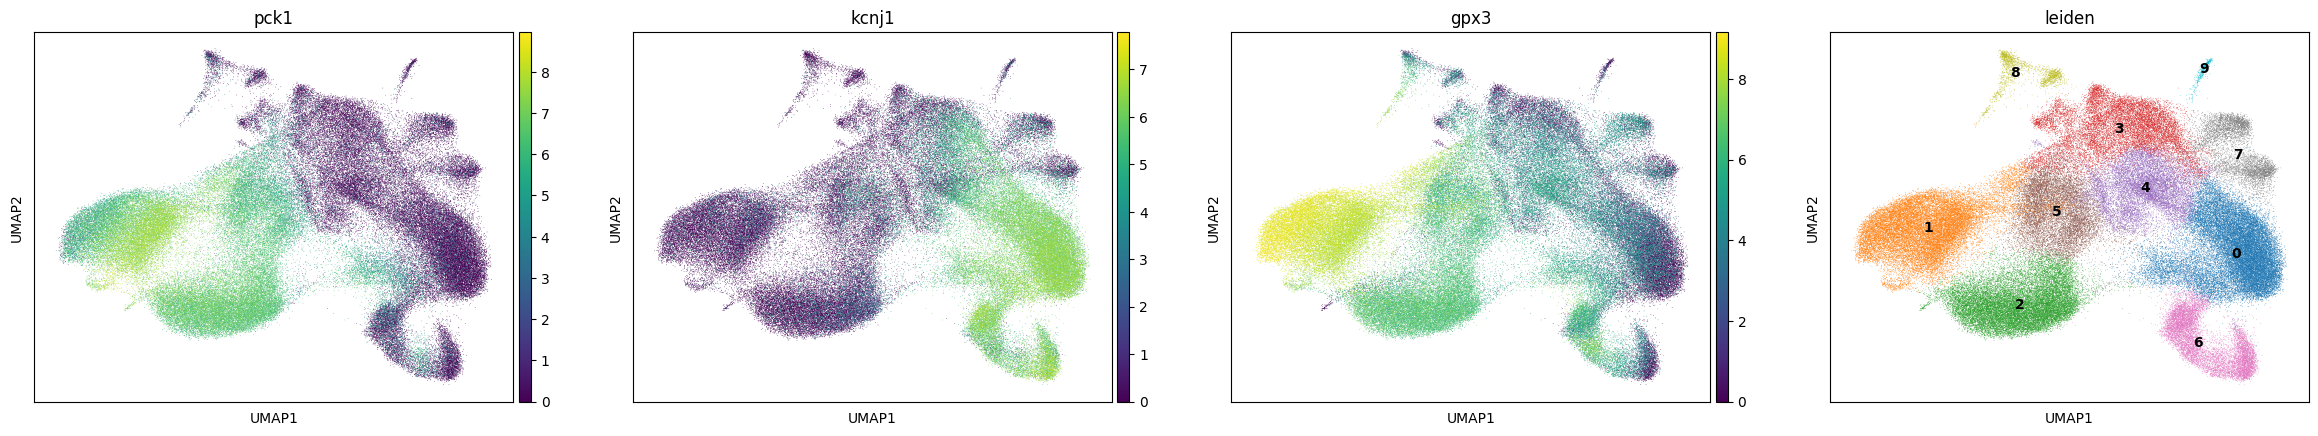

In [194]:
sc.pl.umap(VizgenKidney, color=['pck1','kcnj1','gpx3','leiden'],legend_loc='on data')
plt.show()

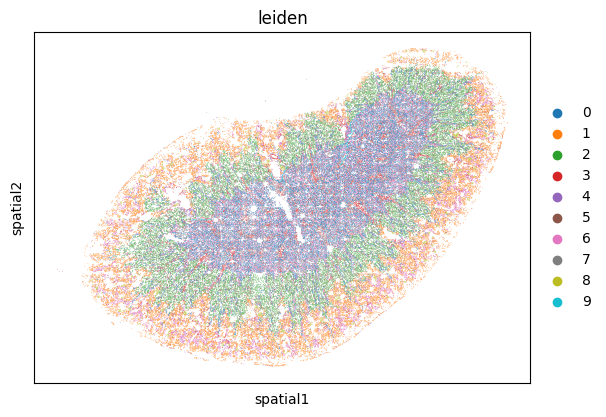

In [199]:
sc.pl.spatial(VizgenKidney, color='leiden', spot_size=100)
plt.show()

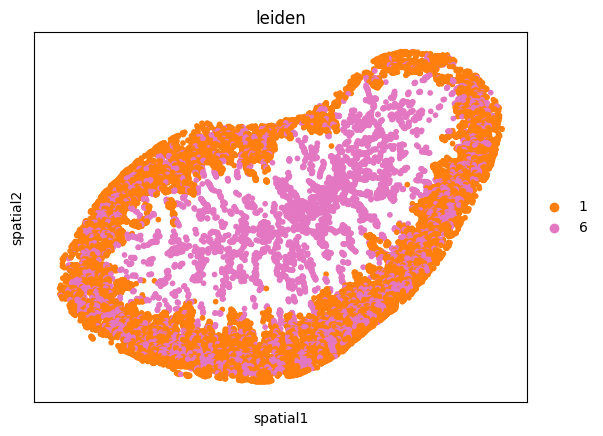

In [282]:
sc.pl.spatial(VizgenKidney[VizgenKidney.obs['leiden'].isin(['1','6'])], color='leiden', spot_size=100)
plt.show()

In [201]:
# Kidney cluster marker genes
markers_kidney.head(20)

0          1       2         3         4         5        6  \
0   ppp1r1a       gpx3   napsa     ptprb    col1a2     napsa   scnn1a   
1     kcnj1      pdzk1   pdzk1     sparc    pdgfra     sparc      mal   
2     nudt4       pck1    pck1       eng  serping1     pdzk1    kcnj1   
3    atp1b1     igfbp4    sod3     plvap    pdgfrb      pck1    nudt4   
4     epcam    fam151a    aqp1  slc9a3r2     prelp       eng   atp1b1   
5       mal     tmem27   pth1r    shank3       eng     epas1     cdh1   
6      cdh1      pth1r    prlr     mmrn2     aebp1      ecm1      clu   
7      spp1        maf   csf1r     epas1      myl9      sod3    wdr72   
8    pcolce       sod3     ak4     podxl      sdc3     plvap     aqp2   
9    tspan8      glyat    glul      cdh5      ecm1    col4a1     krt7   
10   scnn1a  tnfrsf13b    gpx3      esam     tcf21     ptprb    krt18   
11     esam       fmo1     mme      flt1       gsn     pth1r   lgals3   
12     cd81      sfrp2   ms4a1     egfl7     sparc  slc9a3r2     cav1   
13    crip2       glul  tmem27     eltd1    ccdc80      aqp1    hnf1b   
14     dag1     slc2a2    arg2       kdr     epas1       kdr     sdpr   
15     krt7        ak4    darc      nrp1     mxra8    shank3    kcne1   
16      oat       spp1  atp2a2   clec14a    pcolce     prelp     dag1   
17    hnf1b       aqp1    lsp1     gnai2    col4a1     gnai2    cldn7   
18   atp2a2     rnase6    il7r      flt4     gnai2      ehd3    epcam   
19     gas1       prlr   fabp4    gimap4    col4a2    col1a2  arhgdib   

          7         8              9  
0     epcam     sparc          krt18  
1     foxc1     synpo          krt19  
2    atp1b1     podxl           spp1  
3     csf1r  slc9a3r2            clu  
4   tinagl1     aplp1           cdh1  
5     hnf1b     cldn5           krt8  
6      dag1       wt1            mal  
7      gas1      ehd3           krt5  
8    atp1b3      ptrf            cpe  
9    col4a2      nrp1           ptrf  
10    synpo     sfrp2         lgals3  
11    krt18       kdr           krt7  
12     cdh1      dag1        tspan13  
13    calm1    pdgfrb          actn4  
14     ptrf     aebp1          abcc8  
15   col4a1    gimap4        s100a14  
16    gnai2     actn4          gnai2  
17   cnksr3     gnai2         tspan8  
18   tspan8       clu          synpo  
19    cldn7     epas1  4631405k08rik

### Preliminary annotating:
- 0 = epithelial proximal tubule? (pck1)
- 1 = Loop of Henle (kcnj1, spp1, nudt4)
- 2 = epithelial proximal convoluted tubule (pck1, gpx3)
- 3 = pericyte/endo?
- 4 = fenestrated/endothelial cell (Slc9a3r2, plvap)
- 5 = epithelial proximal convoluted tubule (pck1, gpx3)
- 6 = kidney distal convoluted tubule epithelial cell (clu, kcnj1, ppp1r1a)
- 7 = collecting duct epithelial cell (epcam) *this one is ambiguous but spatially is LoH or CD-EC*
- 8 = pericyte/endo (ptprb)
- 9 = collecting duct epithelial cell (Aqp2)
- 10 = podocyte (Synpo, Podxl)
- 11 = epithelial proximal tubule / brush cell (krt)
- 12 = epithelial proximal tubule

### Free annotation:
- 0 = Loop of Henle (kcnj1, nudt4, spp1)
- 1 = epithelial proximal tubule (pck1, pdzk1)
- 2 = epithelial proximal tubule (pdzk1, pck1)
- 3 = endothelial cell (ptprb, sparc, eng, plvap, slc9a3r2)
- 4 = mesangial cell? common markers with liver and pancreatic stellate cells. spatially in medulla
- 5 = endothelial (near cortex)
- 6 = collecting duct epithelial cell (scnn1a), spatially distributed in cortex and medulla
- 7 = collecting duct epithelial cell (epcam), spatially in medulla
- 8 = podocyte (synpo, podxl)
- 9 = distal convoluted tubule (clu, spp1)

In [219]:
kidney_map = {'0':'kidney loop of Henle epithelial cell',
             '1':'epithelial cell of proximal tubule',
             '2':'epithelial cell of proximal tubule',
             '3':'endothelial cell',
             '4':'fibroblast/pericyte/endothelial?',
             '5':'endothelial cell',
             '6':'kidney collecting duct epithelial cell',
             '7':'kidney collecting duct epithelial cell',
             '8':'podocyte',
             '9':'kidney distal convoluted tubule epithelial cell'
             }

VizgenKidney.obs['free_annotation'] = VizgenKidney.obs['leiden'].map(kidney_map)

# Add other cell type categories
VizgenKidney.obs['free_annotation'] = VizgenKidney.obs[
    'free_annotation'].cat.add_categories(['immune cell', 'pericyte'])

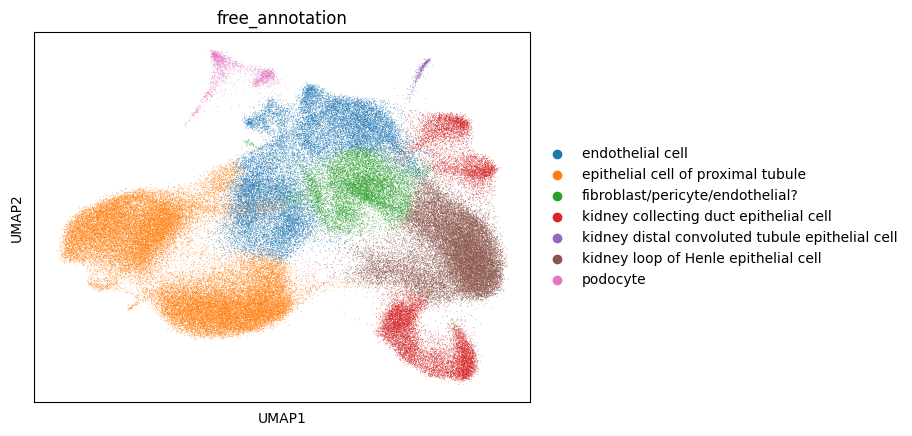

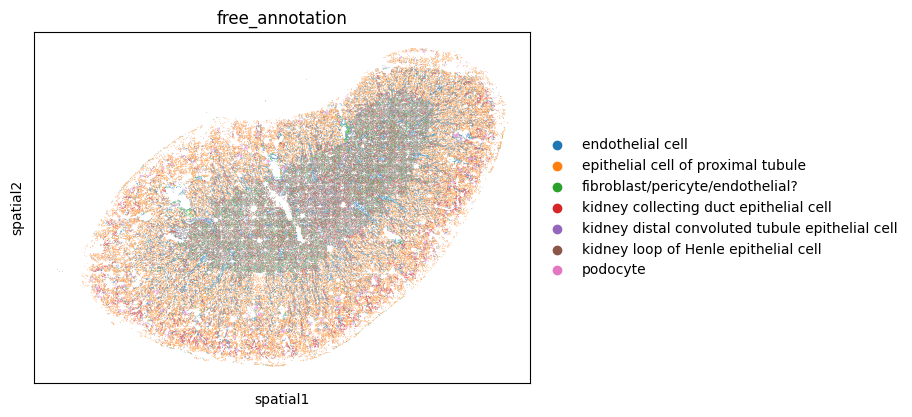

In [220]:
sc.pl.umap(VizgenKidney, color='free_annotation')
plt.show()
sc.pl.spatial(VizgenKidney, color='free_annotation', spot_size=100)
plt.show()

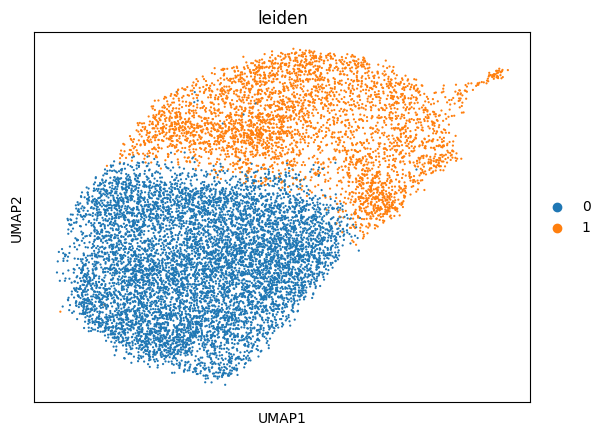

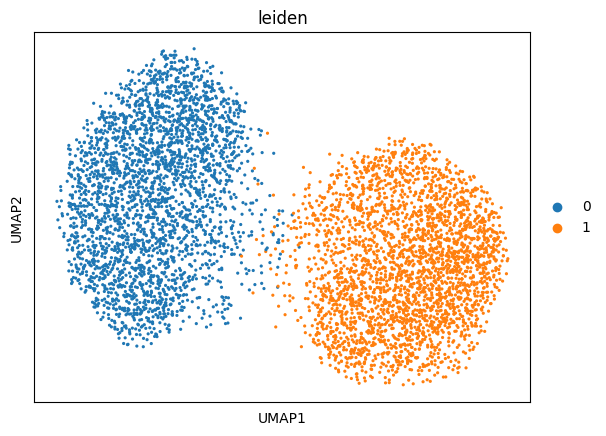

In [223]:
# Subcluster clusters 4 and 7 and 6
VizgenKidney_4 = VizgenKidney[VizgenKidney.obs['leiden'] == '4'].copy()

sc.tl.pca(VizgenKidney_4, svd_solver='arpack') #Compute PCA
sc.pp.neighbors(VizgenKidney_4) #Compute neighborhood graph
sc.tl.umap(VizgenKidney_4)
sc.tl.leiden(VizgenKidney_4, resolution=0.2)
sc.pl.umap(VizgenKidney_4, color='leiden')

VizgenKidney_7 = VizgenKidney[VizgenKidney.obs['leiden'] == '7'].copy()

sc.tl.pca(VizgenKidney_7, svd_solver='arpack') #Compute PCA
sc.pp.neighbors(VizgenKidney_7) #Compute neighborhood graph
sc.tl.umap(VizgenKidney_7)
sc.tl.leiden(VizgenKidney_7, resolution=0.2)
sc.pl.umap(VizgenKidney_7, color='leiden')

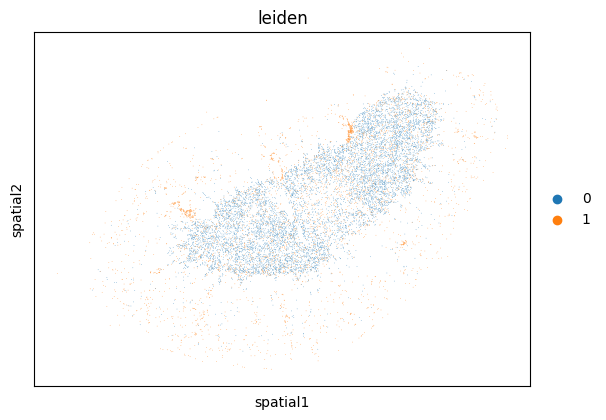

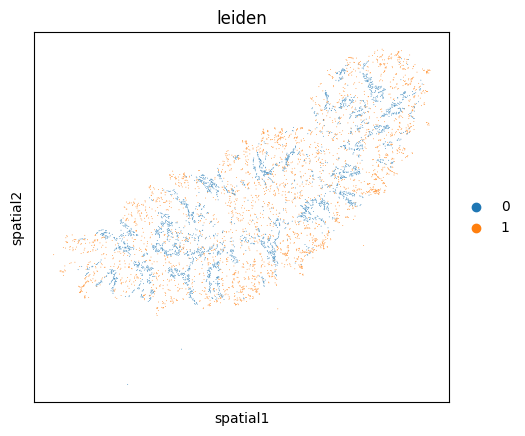

In [228]:
# Spatial subcluster plots
sc.pl.spatial(VizgenKidney_4, color='leiden', spot_size=100)
sc.pl.spatial(VizgenKidney_7, color='leiden', spot_size=100)

In [225]:
# Get the subclustered DE genes
# Cluster 4
sc.tl.rank_genes_groups(VizgenKidney_4, 'leiden')
markers_kidney_4 = pd.DataFrame(VizgenKidney_4.uns['rank_genes_groups']['names'])
markers_kidney_4.head(10)

0       1
0   atp1b1  h2-ab1
1    epcam  laptm5
2   pdgfra    ctss
3    nudt4    c1qb
4  ppp1r1a    c1qa
5     cdh1    emr1
6    kcnj1    cybb
7     spp1   csf1r
8  tinagl1   h2-aa
9     myl9  cx3cr1

- 0 = collecting duct epithelial (epcam)
- 1 = immune cell

In [226]:
# Cluster 7
sc.tl.rank_genes_groups(VizgenKidney_7, 'leiden')
markers_kidney_7 = pd.DataFrame(VizgenKidney_7.uns['rank_genes_groups']['names'])
markers_kidney_7.head(10)

0         1
0   foxc1      aqp1
1    dag1      spp1
2    sod3    atp1b1
3     oat    pcolce
4   krt18    tm4sf1
5   epcam      il7r
6     cpe  pnliprp2
7   csf1r  serpinf1
8  col4a1      esam
9  tspan8     trat1

- 0 = pericyte
- 1 = endothelial

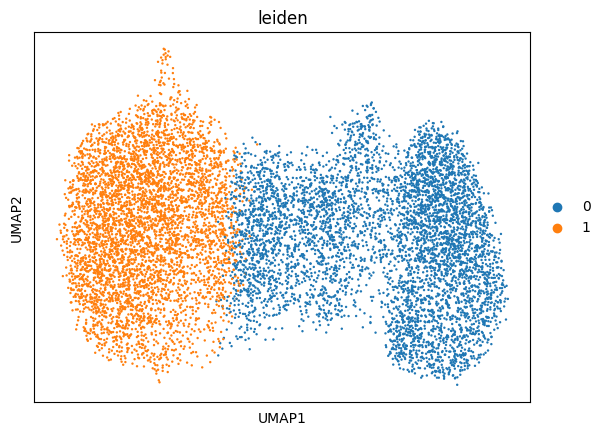

In [283]:
# Also subcluster 6
VizgenKidney_6 = VizgenKidney[VizgenKidney.obs['leiden'] == '6'].copy()

sc.tl.pca(VizgenKidney_6, svd_solver='arpack') #Compute PCA
sc.pp.neighbors(VizgenKidney_6) #Compute neighborhood graph
sc.tl.umap(VizgenKidney_6)
sc.tl.leiden(VizgenKidney_6, resolution=0.2)
sc.pl.umap(VizgenKidney_6, color='leiden')

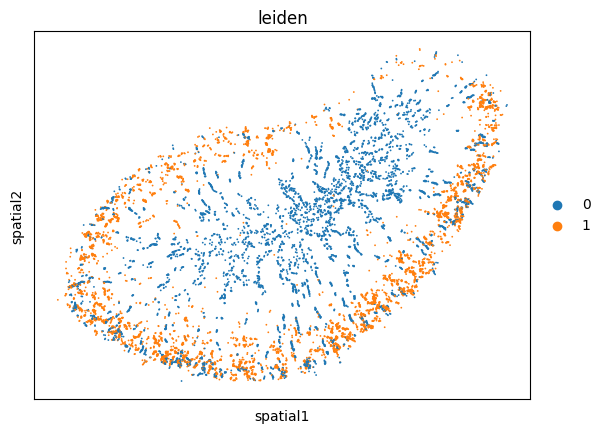

In [284]:
sc.pl.spatial(VizgenKidney_6, color='leiden', spot_size=30)

In [285]:
# Cluster 6
sc.tl.rank_genes_groups(VizgenKidney_6, 'leiden')
markers_kidney_6 = pd.DataFrame(VizgenKidney_6.uns['rank_genes_groups']['names'])
markers_kidney_6.head(10)

0        1
0     aqp2     spp1
1  arhgdib      clu
2     cav1    pth1r
3     krt7  ppp1r1a
4    krt18     sdpr
5    epcam   pcolce
6    gnai2     gpx3
7   col4a1   atp1b1
8      oat    aebp1
9    calm1   tm4sf1

- 0 = collecting duct epithelial cell
- 1 = distal convoluted tubule

In [286]:
# Annotate and transfer back to master liver object

kidney_4_map = {'0':'kidney collecting duct epithelial cell',
                '1': 'immune cell'
                 }
kidney_7_map = {'0':'pericyte',
                '1': 'endothelial cell'
                 }
kidney_6_map = {'0':'kidney collecting duct epithelial cell',
                '1': 'kidney distal convoluted tubule epithelial cell'
                 }

VizgenKidney_4.obs['free_annotation'] = VizgenKidney_4.obs['leiden'].map(kidney_4_map)
VizgenKidney_7.obs['free_annotation'] = VizgenKidney_7.obs['leiden'].map(kidney_7_map)
VizgenKidney_6.obs['free_annotation'] = VizgenKidney_6.obs['leiden'].map(kidney_6_map)

for ind in VizgenKidney_4.obs.index:
    VizgenKidney.obs.loc[ind,'free_annotation'] = VizgenKidney_4.obs.loc[ind,'free_annotation']
for ind in VizgenKidney_7.obs.index:
    VizgenKidney.obs.loc[ind,'free_annotation'] = VizgenKidney_7.obs.loc[ind,'free_annotation']
for ind in VizgenKidney_6.obs.index:
    VizgenKidney.obs.loc[ind,'free_annotation'] = VizgenKidney_6.obs.loc[ind,'free_annotation']
    
# Remove unused categories
VizgenKidney.obs['free_annotation'] = VizgenKidney.obs['free_annotation'].cat.remove_unused_categories()

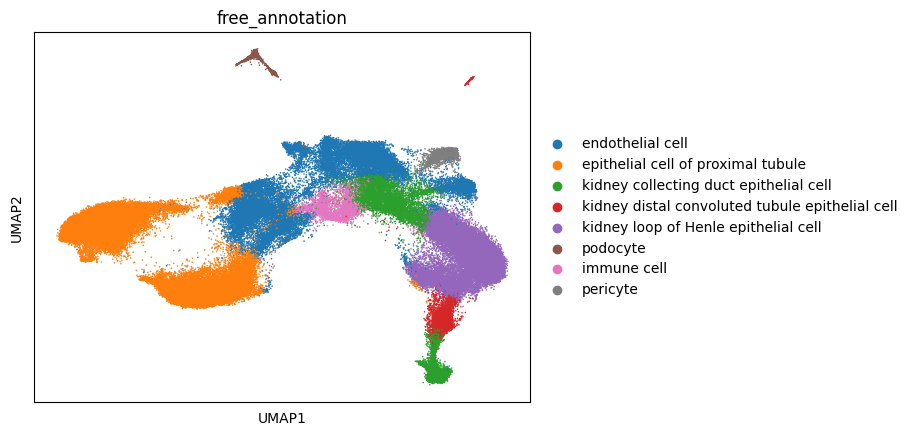

/data01/jonathan.liu/miniconda3/envs/jupyter/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


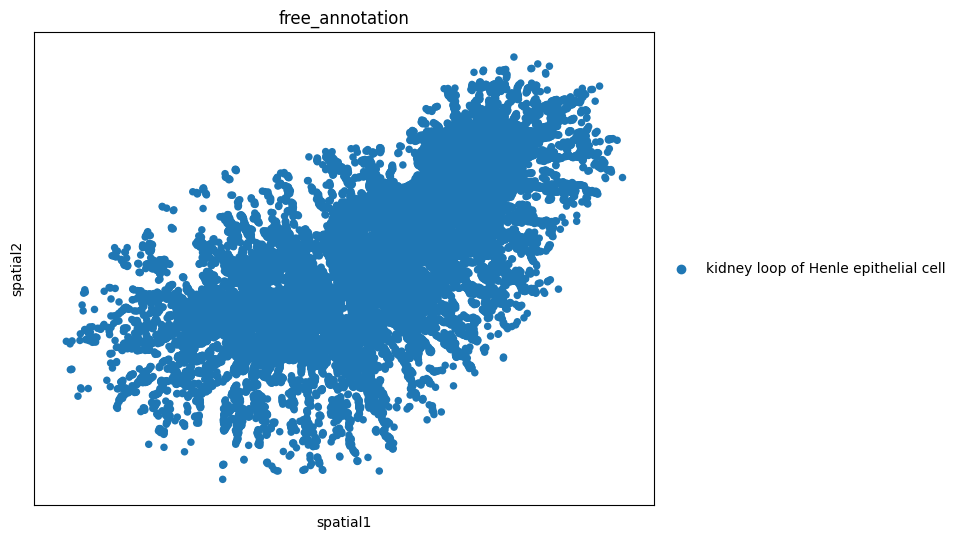

In [287]:
# Visualize the final results
#sc.tl.umap(VizgenKidney, min_dist=0.1)
sc.pl.umap(VizgenKidney, color='free_annotation', size=5)

fig, ax = plt.subplots(figsize=(8,8))
sc.pl.spatial(VizgenKidney[
    VizgenKidney.obs['free_annotation'] == 'kidney loop of Henle epithelial cell'], 
              color='free_annotation', spot_size=100, show=False, ax=ax)
plt.show()


In [280]:
# Rescale the spatial coordinates from mosaic pixel to micron units
dataPath = '/mnt/ibm_lg/spatial-seq/MERSCOPE/preprocessed_data/'
size_of_one_pixel = {}

for experiment in experimentName:
    transformation_matrix = np.loadtxt(os.path.join(
        dataPath, experiment, 'region_0', 'images', 'micron_to_mosaic_pixel_transform.csv'))

    size_of_one_pixel[experiment] = 1 / transformation_matrix[0,0]

VizgenLiver.obsm['spatial'] = VizgenLiver.obsm['spatial'] * size_of_one_pixel[experimentName[0]]
VizgenKidney.obsm['spatial'] = VizgenKidney.obsm['spatial'] * size_of_one_pixel[experimentName[1]]

In [288]:
# Save the results
saveDir = '../../../results/'

# Save the h5ad files
VizgenLiver.write(saveDir + 'MERFISH_liver_object.h5ad')
VizgenKidney.write(saveDir + 'MERFISH_kidney_object.h5ad')

print('Results saved.')

Results saved.
